In [1]:
import pandas as pd
import squarify
import collections
import re
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import numpy as np

import torch
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score
from sklearn.preprocessing import label_binarize, LabelEncoder
from itertools import cycle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

In [2]:
df = pd.read_csv("tweets_live9.csv")

In [3]:
df.head()

,UserTags,TimeStamps,Tweets,Replies,Retweets,Likes
0,Angela Gardner\n@AngieG4ability\n·\n12h,2024-06-29T19:44:38.000Z,Investing in our children is the best thing. A...,1,3,16
1,Black Lives Matter\n@Blklivesmatter\n·\n12h,2024-06-29T19:29:52.000Z,Black Boy JOY Alert!\n\nWe’re proud to support...,3,29,195
2,"Gabrielle A. Perry, MPH\n@GeauxGabrielle\n·\nJ...",2024-06-28T14:52:07.000Z,The homeless will be rounded up by police and ...,1.9K,30K,91K
3,"Bryan H., Esq.\n@X_BryanH\n·\nJun 28",2024-06-28T14:55:27.000Z,The Supreme Court has:\n\n-Overturned Roe v. W...,8.5K,40K,136K
4,Black Lives Matter\n@Blklivesmatter\n·\nJun 27,2024-06-27T02:00:23.000Z,CNN's exclusion of Black-owned media from the ...,8,39,69


In [4]:
df['TimeStamps'] = pd.to_datetime(df['TimeStamps'])

def clean_tweet(tweet):
    if isinstance(tweet, str):
        tweet = re.sub(r'http\S+', '', tweet)  # Remove URLs
        tweet = re.sub(r'@\S+', '', tweet)     # Remove mentions
        tweet = re.sub(r'#\S+', '', tweet)     # Remove hashtags
        tweet = re.sub(r'[^A-Za-z0-9\s]', '', tweet)  # Remove special characters
        tweet = tweet.lower()  # Convert to lowercase
    else:
        tweet = ''  # If the tweet is not a string, convert to an empty string
    return tweet

df['Cleaned_Tweets'] = df['Tweets'].apply(clean_tweet)

# Process the numeric columns
def process_k_values(value):
    value = str(value)
    if 'K' in value:
        return float(value.replace('K', '')) * 1000
    return float(value)

df['Replies'] = df['Replies'].apply(process_k_values)
df['Retweets'] = df['Retweets'].apply(process_k_values)
df['Likes'] = df['Likes'].apply(process_k_values)


In [5]:
df

,UserTags,TimeStamps,Tweets,Replies,Retweets,Likes,Cleaned_Tweets
0,Angela Gardner\n@AngieG4ability\n·\n12h,2024-06-29 19:44:38+00:00,Investing in our children is the best thing. A...,1.0,3.0,16.0,investing in our children is the best thing an...
1,Black Lives Matter\n@Blklivesmatter\n·\n12h,2024-06-29 19:29:52+00:00,Black Boy JOY Alert!\n\nWe’re proud to support...,3.0,29.0,195.0,black boy joy alert\n\nwere proud to support t...
2,"Gabrielle A. Perry, MPH\n@GeauxGabrielle\n·\nJ...",2024-06-28 14:52:07+00:00,The homeless will be rounded up by police and ...,1900.0,30000.0,91000.0,the homeless will be rounded up by police and ...
3,"Bryan H., Esq.\n@X_BryanH\n·\nJun 28",2024-06-28 14:55:27+00:00,The Supreme Court has:\n\n-Overturned Roe v. W...,8500.0,40000.0,136000.0,the supreme court has\n\noverturned roe v wade...
4,Black Lives Matter\n@Blklivesmatter\n·\nJun 27,2024-06-27 02:00:23+00:00,CNN's exclusion of Black-owned media from the ...,8.0,39.0,69.0,cnns exclusion of blackowned media from the pr...
...,...,...,...,...,...,...,...
459,"Legal Defense Fund\n@NAACP_LDF\n·\nJan 27, 2023",2023-01-27 19:01:01+00:00,Tyre Nichols loved to take photos of sunsets. ...,2.0,136.0,367.0,tyre nichols loved to take photos of sunsets h...
460,"COLONIALISM IS FALLING, PALESTINE WILL BE FREE...",2023-01-27 15:16:05+00:00,Diversifying the police force doesn’t end raci...,1000.0,9500.0,38000.0,diversifying the police force doesnt end racis...
461,"Haymarket Books\n@haymarketbooks\n·\nJan 27, 2023",2023-01-27 18:37:17+00:00,It’s still defund and abolish the police,11.0,698.0,2600.0,its still defund and abolish the police
462,"Haymarket Books\n@haymarketbooks\n·\nJan 24, 2023",2023-01-24 19:50:08+00:00,"If you are a high school student in Florida, w...",20.0,1800.0,3500.0,if you are a high school student in florida we...


In [6]:
def get_sentiment(tweet):
    analysis = TextBlob(tweet)
    return analysis.sentiment.polarity

df['Sentiment'] = df['Cleaned_Tweets'].apply(get_sentiment)


In [7]:
df

,UserTags,TimeStamps,Tweets,Replies,Retweets,Likes,Cleaned_Tweets,Sentiment
0,Angela Gardner\n@AngieG4ability\n·\n12h,2024-06-29 19:44:38+00:00,Investing in our children is the best thing. A...,1.0,3.0,16.0,investing in our children is the best thing an...,1.000000
1,Black Lives Matter\n@Blklivesmatter\n·\n12h,2024-06-29 19:29:52+00:00,Black Boy JOY Alert!\n\nWe’re proud to support...,3.0,29.0,195.0,black boy joy alert\n\nwere proud to support t...,0.522222
2,"Gabrielle A. Perry, MPH\n@GeauxGabrielle\n·\nJ...",2024-06-28 14:52:07+00:00,The homeless will be rounded up by police and ...,1900.0,30000.0,91000.0,the homeless will be rounded up by police and ...,0.000000
3,"Bryan H., Esq.\n@X_BryanH\n·\nJun 28",2024-06-28 14:55:27+00:00,The Supreme Court has:\n\n-Overturned Roe v. W...,8500.0,40000.0,136000.0,the supreme court has\n\noverturned roe v wade...,0.350000
4,Black Lives Matter\n@Blklivesmatter\n·\nJun 27,2024-06-27 02:00:23+00:00,CNN's exclusion of Black-owned media from the ...,8.0,39.0,69.0,cnns exclusion of blackowned media from the pr...,0.100000
...,...,...,...,...,...,...,...,...
459,"Legal Defense Fund\n@NAACP_LDF\n·\nJan 27, 2023",2023-01-27 19:01:01+00:00,Tyre Nichols loved to take photos of sunsets. ...,2.0,136.0,367.0,tyre nichols loved to take photos of sunsets h...,0.325000
460,"COLONIALISM IS FALLING, PALESTINE WILL BE FREE...",2023-01-27 15:16:05+00:00,Diversifying the police force doesn’t end raci...,1000.0,9500.0,38000.0,diversifying the police force doesnt end racis...,0.000000
461,"Haymarket Books\n@haymarketbooks\n·\nJan 27, 2023",2023-01-27 18:37:17+00:00,It’s still defund and abolish the police,11.0,698.0,2600.0,its still defund and abolish the police,0.000000
462,"Haymarket Books\n@haymarketbooks\n·\nJan 24, 2023",2023-01-24 19:50:08+00:00,"If you are a high school student in Florida, w...",20.0,1800.0,3500.0,if you are a high school student in florida we...,0.223333


In [8]:
df.describe()

,Replies,Retweets,Likes,Sentiment
count,456.000000,458.000000,464.00000,464.000000
mean,175.173246,840.903930,3271.62069,0.080388
std,1838.239872,3633.603078,13722.75720,0.236685
min,1.000000,1.000000,1.00000,-0.800000
25%,6.000000,9.000000,33.75000,-0.036865
50%,15.000000,25.000000,85.50000,0.027778
75%,35.000000,124.000000,416.75000,0.200000
max,38000.000000,43000.000000,139000.00000,1.000000


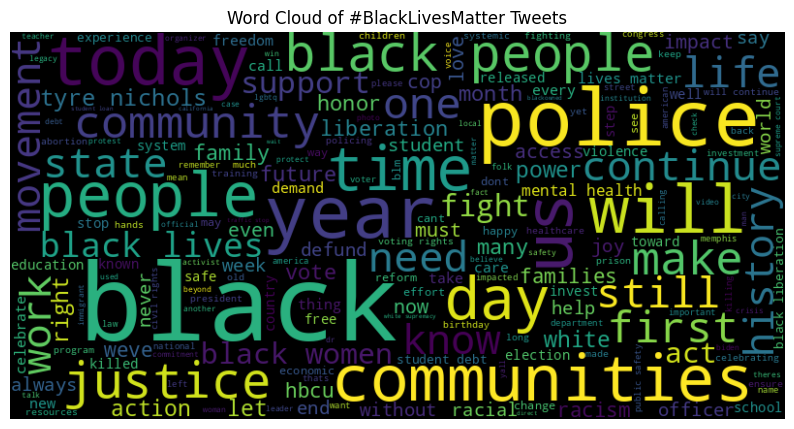

In [9]:
# Combine all cleaned tweets into one large string
all_words = ' '.join([tweet for tweet in df['Cleaned_Tweets']])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110).generate(all_words)

# Plot the word cloud
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Word Cloud of #BlackLivesMatter Tweets')
plt.show()


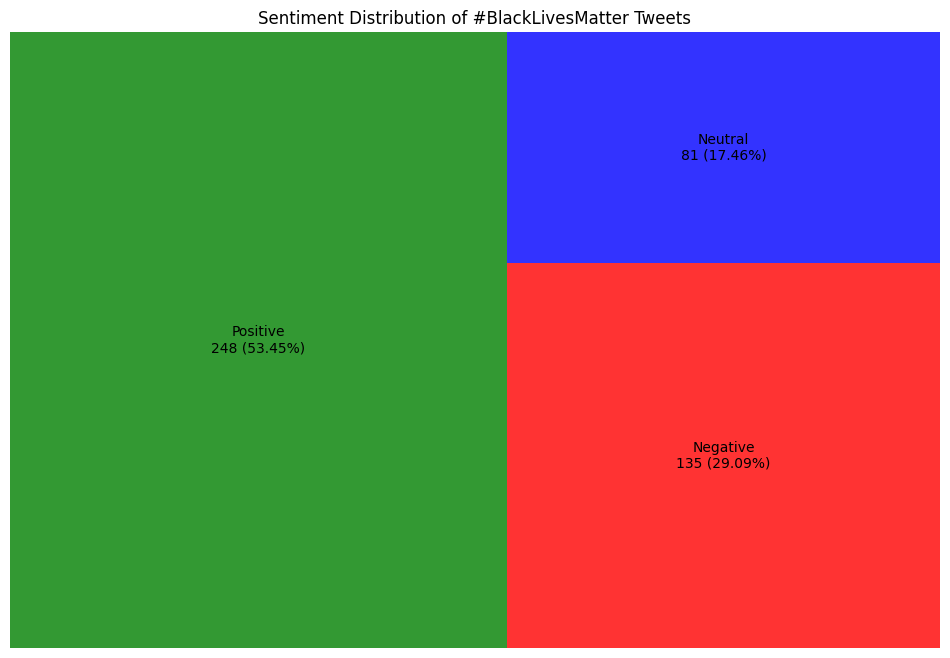

In [10]:
# Create sentiment labels
df['Sentiment_Label'] = df['Sentiment'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))
# Prepare data for the treemap
sentiment_counts = df['Sentiment_Label'].value_counts().reset_index()
sentiment_counts.columns = ['Sentiment', 'Count']
# Calculate percentages
total_count = sentiment_counts['Count'].sum()
sentiment_counts['Percentage'] = (sentiment_counts['Count'] / total_count) * 100
sentiment_counts['Label'] = sentiment_counts.apply(lambda x: f"{x['Sentiment']}\n{x['Count']} ({x['Percentage']:.2f}%)", axis=1)

# Plot the treemap with percentages
plt.figure(figsize=(12, 8))
colors = ['green', 'red', 'blue']
squarify.plot(sizes=sentiment_counts['Count'], label=sentiment_counts['Label'], color=colors, alpha=.8)
plt.title('Sentiment Distribution of #BlackLivesMatter Tweets')
plt.axis('off')
plt.show()

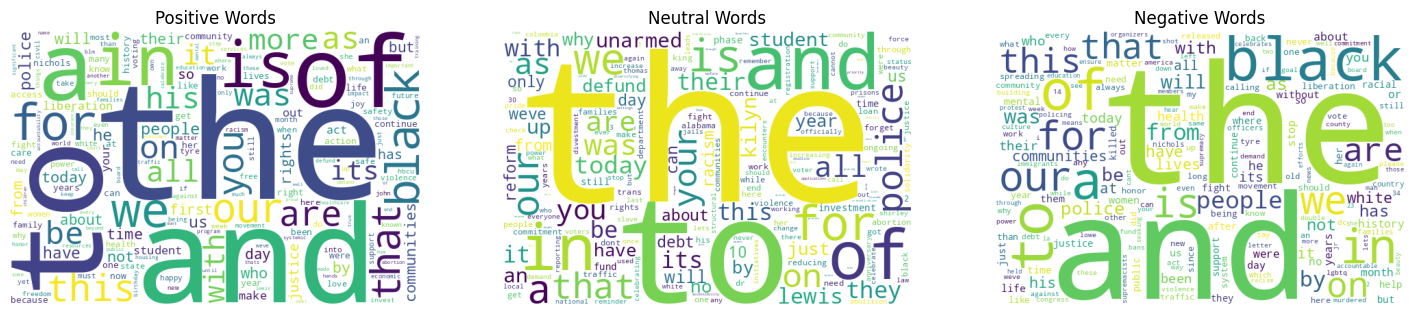

In [11]:
# Function to extract most common words
def get_most_common_words(text_series, num_words=464):
    all_words = ' '.join(text_series).split()
    common_words = Counter(all_words).most_common(num_words)
    return dict(common_words)

# Extract words for each sentiment
positive_words = get_most_common_words(df[df['Sentiment_Label'] == 'Positive']['Cleaned_Tweets'])
neutral_words = get_most_common_words(df[df['Sentiment_Label'] == 'Neutral']['Cleaned_Tweets'])
negative_words = get_most_common_words(df[df['Sentiment_Label'] == 'Negative']['Cleaned_Tweets'])

# Plot word clouds for each sentiment
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(WordCloud(width=600, height=400, background_color='white').generate_from_frequencies(positive_words))
plt.title('Positive Words')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(WordCloud(width=600, height=400, background_color='white').generate_from_frequencies(neutral_words))
plt.title('Neutral Words')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(WordCloud(width=600, height=400, background_color='white').generate_from_frequencies(negative_words))
plt.title('Negative Words')
plt.axis('off')

plt.show()


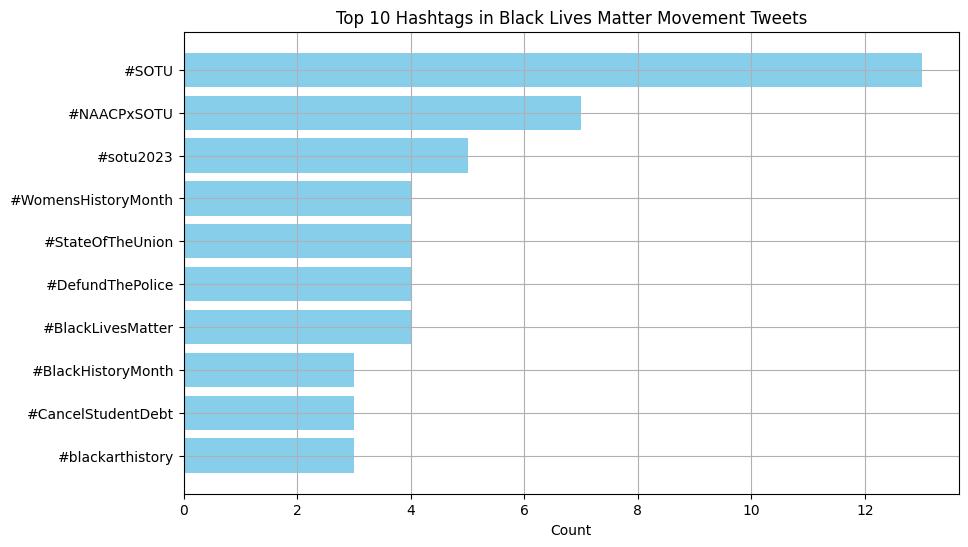

In [12]:
# Ensure all tweets are strings and handle non-string entries
df['Tweets'] = df['Tweets'].astype(str)

# Extract hashtags from the original tweets
df['Hashtags'] = df['Tweets'].apply(lambda x: re.findall(r'#\w+', x))

# Flatten the list of hashtags and count frequencies
all_hashtags = [hashtag for sublist in df['Hashtags'] for hashtag in sublist]
hashtag_counts = collections.Counter(all_hashtags)

# Convert to DataFrame for easier handling
hashtag_df = pd.DataFrame(hashtag_counts.most_common(10), columns=['Hashtag', 'Count'])

# Plot the most common hashtags
plt.figure(figsize=(10, 6))
plt.barh(hashtag_df['Hashtag'], hashtag_df['Count'], color='skyblue')
plt.xlabel('Count')
plt.title('Top 10 Hashtags in Black Lives Matter Movement Tweets')
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()

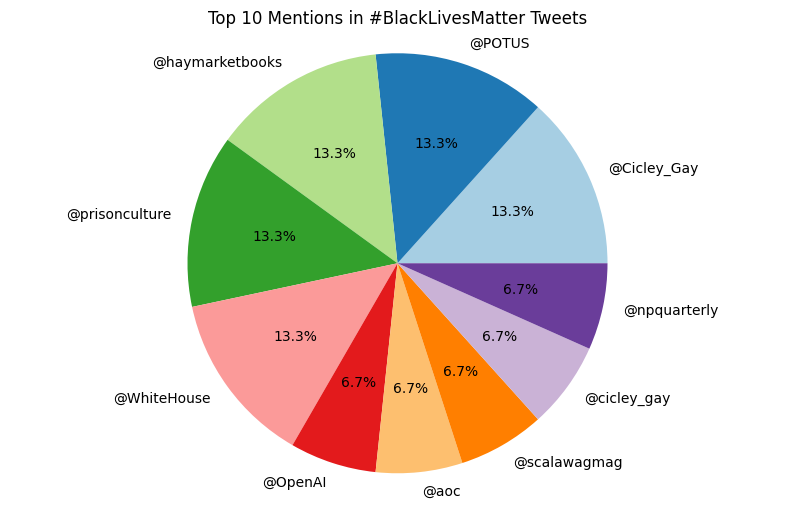

In [13]:
# Extract mentions from the original tweets
df['Mentions'] = df['Tweets'].apply(lambda x: re.findall(r'@\w+', x))

# Flatten the list of mentions and count frequencies
all_mentions = [mention for sublist in df['Mentions'] for mention in sublist]
mention_counts = collections.Counter(all_mentions)

# Convert to DataFrame for easier handling
mention_df = pd.DataFrame(mention_counts.most_common(10), columns=['Mention', 'Count'])
# Plot the most common mentions as a pie chart
plt.figure(figsize=(10, 6))
plt.pie(mention_df['Count'], labels=mention_df['Mention'], autopct='%1.1f%%', colors=plt.cm.Paired(range(len(mention_df))))
plt.title('Top 10 Mentions in #BlackLivesMatter Tweets')
plt.axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle
plt.show()


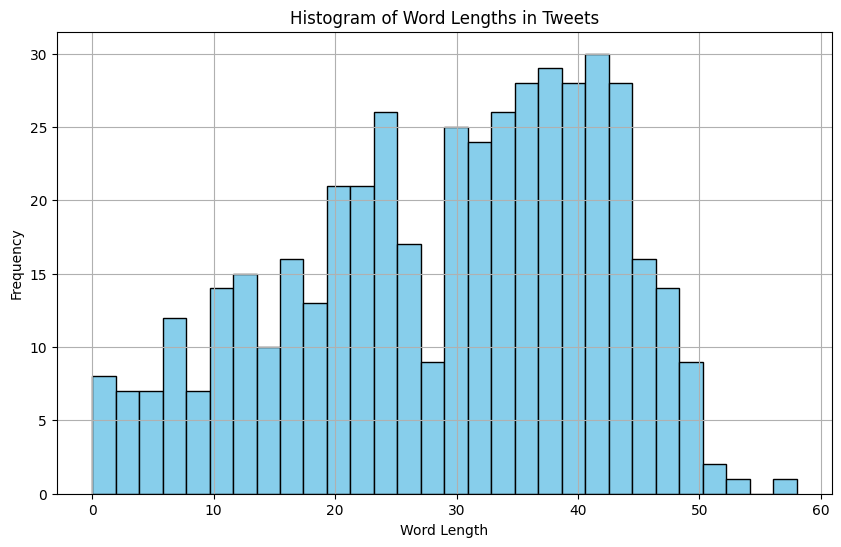

In [14]:
# Calculate the length of words in each tweet
df['Word_Lengths'] = df['Cleaned_Tweets'].apply(lambda x: len(x.split()))

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(df['Word_Lengths'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Word Lengths in Tweets')
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


C:\Users\FABIUS\AppData\Local\Temp\ipykernel_1460\1230231072.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Sentiment_Label', y='Word_Lengths', data=df, palette="rocket")


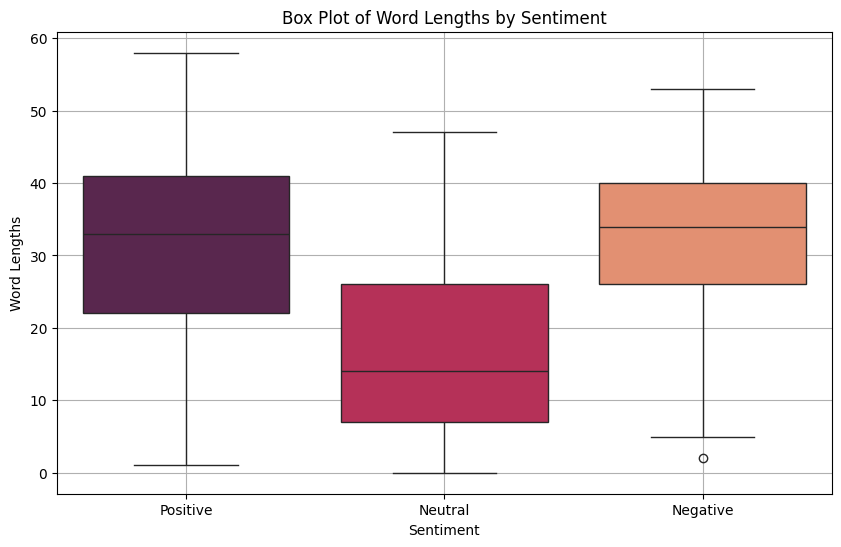

In [15]:
# Create a box plot for word lengths based on sentiment
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='Sentiment_Label', y='Word_Lengths', data=df, palette="rocket")
ax.set_title('Box Plot of Word Lengths by Sentiment')
ax.set_xlabel('Sentiment')
ax.set_ylabel('Word Lengths')
plt.grid(True)
plt.show()

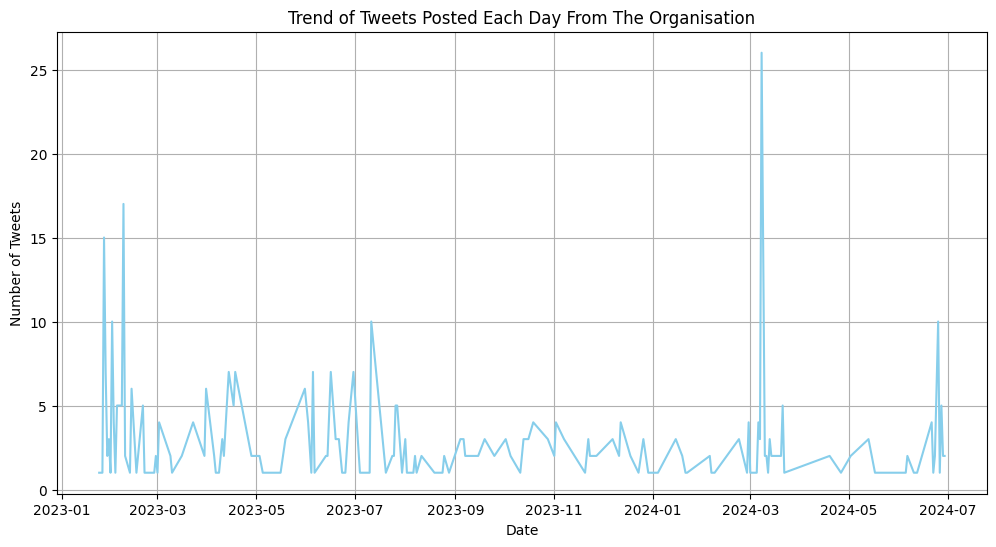

In [16]:

# Extract the date from the TimeStamp
df['Date'] = df['TimeStamps'].dt.date

# Plot the trend of tweets posted each day
daily_tweets = df.groupby('Date').size()
plt.figure(figsize=(12, 6))
daily_tweets.plot(kind='line', color='skyblue')
plt.title('Trend of Tweets Posted Each Day From The Organisation')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.grid(True)
plt.show()


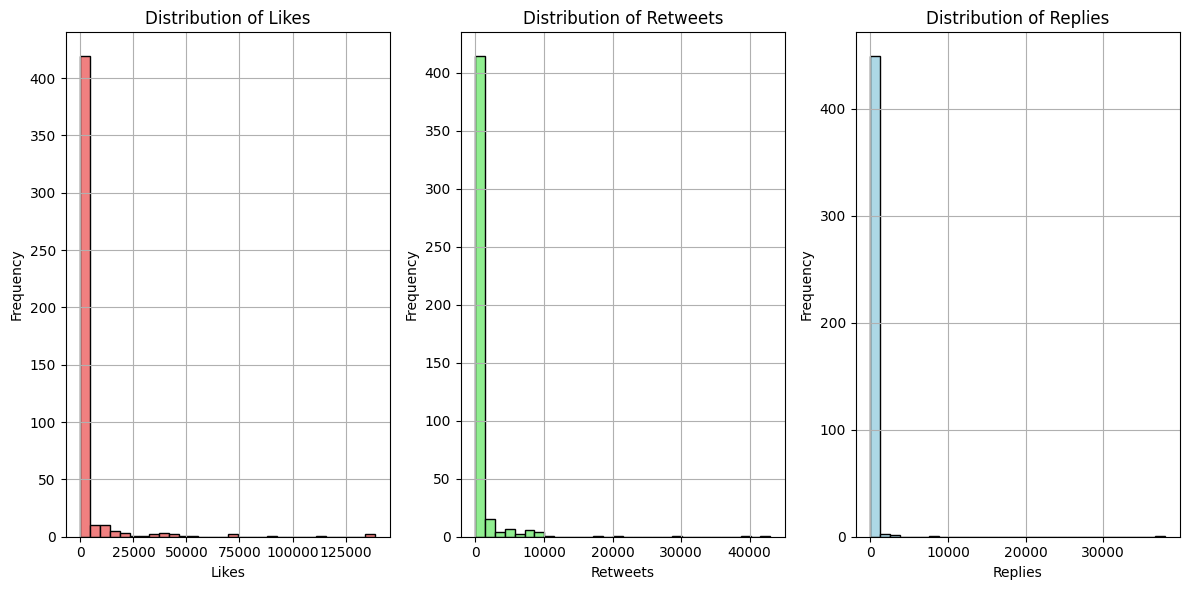

In [17]:

# Plot the distribution of likes, retweets, and replies
plt.figure(figsize=(12, 6))

# Likes
plt.subplot(1, 3, 1)
plt.hist(df['Likes'], bins=30, color='lightcoral', edgecolor='black')
plt.title('Distribution of Likes')
plt.xlabel('Likes')
plt.ylabel('Frequency')
plt.grid(True)

# Retweets
plt.subplot(1, 3, 2)
plt.hist(df['Retweets'], bins=30, color='lightgreen', edgecolor='black')
plt.title('Distribution of Retweets')
plt.xlabel('Retweets')
plt.ylabel('Frequency')
plt.grid(True)

# Replies
plt.subplot(1, 3, 3)
plt.hist(df['Replies'], bins=30, color='lightblue', edgecolor='black')
plt.title('Distribution of Replies')
plt.xlabel('Replies')
plt.ylabel('Frequency')
plt.grid(True)

plt.tight_layout()
plt.show()


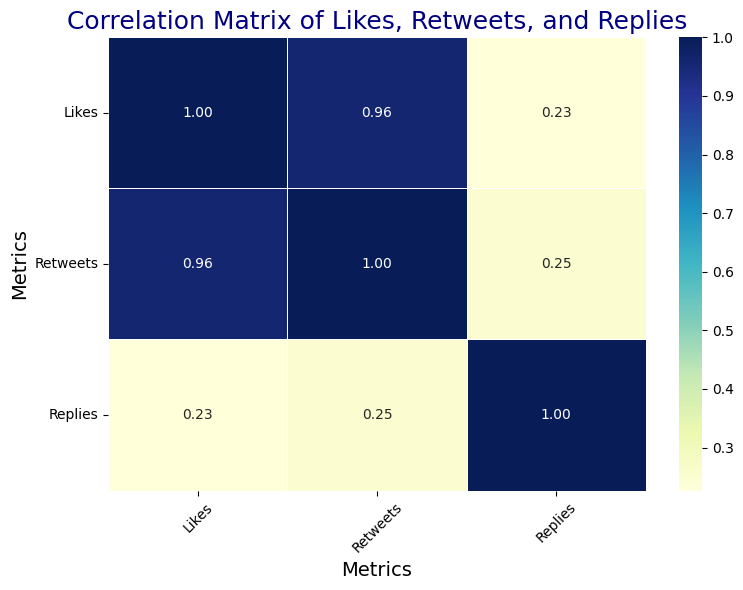

In [18]:

# Calculate the correlation matrix
corr_matrix = df[['Likes', 'Retweets', 'Replies']].corr()

# Plot the heatmap with enhancements
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix of Likes, Retweets, and Replies', fontsize=18, color='navy')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Metrics', fontsize=14)
plt.tight_layout()
plt.show()

C:\Users\FABIUS\AppData\Local\Temp\ipykernel_1460\2447067296.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Hour', y='Likes', data=df, palette='cool')
C:\Users\FABIUS\AppData\Local\Temp\ipykernel_1460\2447067296.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Hour', y='Retweets', data=df, palette='cool')
C:\Users\FABIUS\AppData\Local\Temp\ipykernel_1460\2447067296.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Hour', y='Replies', data=df, palette='cool')


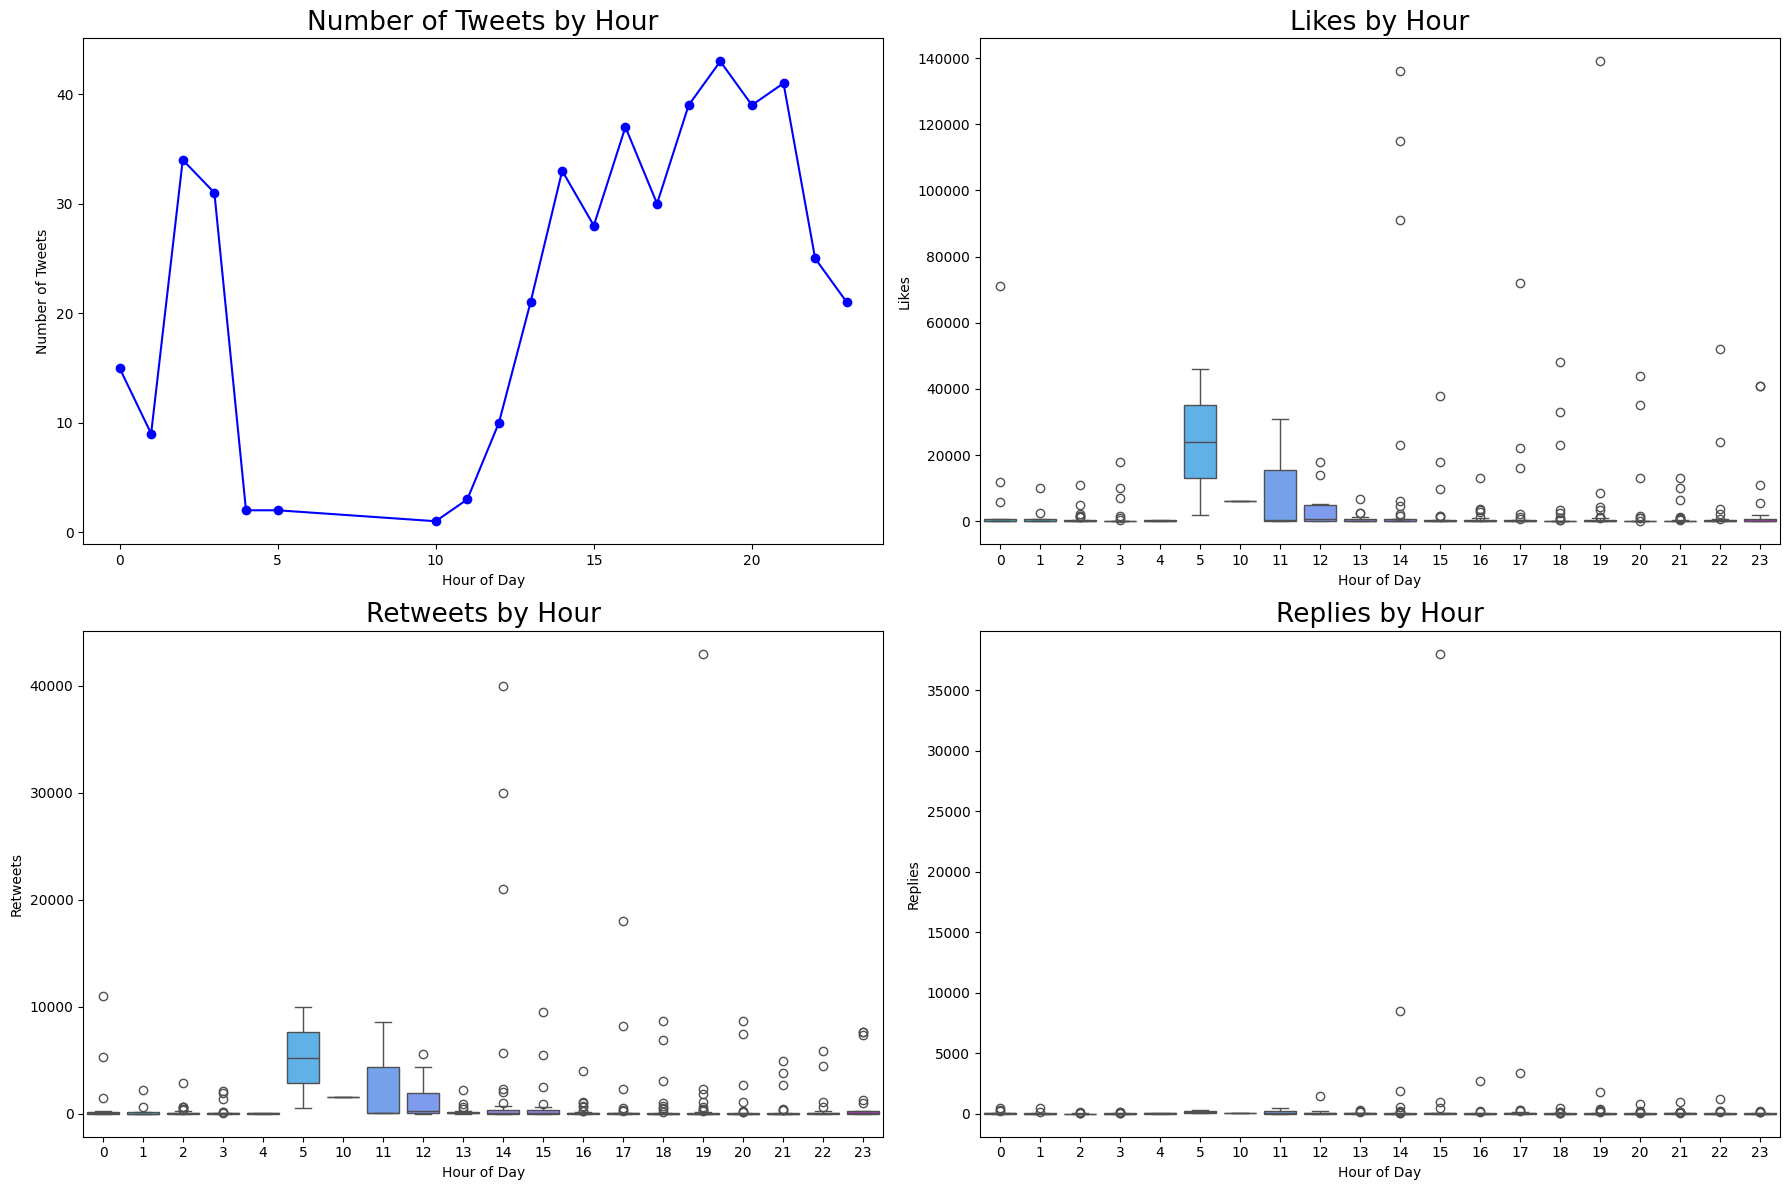

In [19]:
# Extract the hour from the TimeStamps
df['Hour'] = df['TimeStamps'].dt.hour

# Calculate the number of tweets per hour
tweets_per_hour = df.groupby('Hour').size()

# Create a single figure with subplots
plt.figure(figsize=(18, 12))

# Line plot for number of Tweets per Hour
plt.subplot(2, 2, 1)
plt.plot(tweets_per_hour, marker='o', linestyle='-', color='b')
plt.title("Number of Tweets by Hour", fontsize=19, color='k')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Tweets')

# Box plot for Likes by Hour
plt.subplot(2, 2, 2)
sns.boxplot(x='Hour', y='Likes', data=df, palette='cool')
plt.title("Likes by Hour", fontsize=19, color='k')
plt.xlabel('Hour of Day')
plt.ylabel('Likes')

# Box plot for Retweets by Hour
plt.subplot(2, 2, 3)
sns.boxplot(x='Hour', y='Retweets', data=df, palette='cool')
plt.title("Retweets by Hour", fontsize=19, color='k')
plt.xlabel('Hour of Day')
plt.ylabel('Retweets')

# Box plot for Replies by Hour
plt.subplot(2, 2, 4)
sns.boxplot(x='Hour', y='Replies', data=df, palette='cool')
plt.title("Replies by Hour", fontsize=19, color='k')
plt.xlabel('Hour of Day')
plt.ylabel('Replies')

plt.tight_layout()
plt.show()

In [38]:
# Split the data
X = df['Cleaned_Tweets']
y = df['Sentiment_Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize the text data
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Train the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_tfidf, y_train)

# Evaluate the model
y_pred_log_reg = log_reg.predict(X_test_tfidf)
print("Logistic Regression:")
print(classification_report(y_test, y_pred_log_reg))
print("Accuracy:", accuracy_score(y_test, y_pred_log_reg))


Logistic Regression:
              precision    recall  f1-score   support

           0       1.00      0.08      0.14        26
           1       0.00      0.00      0.00        20
           2       0.52      1.00      0.68        47

    accuracy                           0.53        93
   macro avg       0.51      0.36      0.27        93
weighted avg       0.54      0.53      0.38        93

Accuracy: 0.5268817204301075


C:\Users\FABIUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\FABIUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\FABIUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [44]:
# Encode sentiment labels to numeric values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Train the XGBoost model
xgb_model = xgb.XGBClassifier(eval_metric='mlogloss')
xgb_model.fit(X_train_tfidf, y_train_encoded)

# Evaluate the model
y_pred_xgb = xgb_model.predict(X_test_tfidf)
print("XGBoost:")
print(classification_report(y_test_encoded, y_pred_xgb, target_names=label_encoder.classes_))
print("Accuracy:", accuracy_score(y_test_encoded, y_pred_xgb))


XGBoost:


TypeError: object of type 'numpy.int32' has no len()

In [22]:
# Encode the labels
label_encoder = LabelEncoder()
df['Sentiment_Label'] = label_encoder.fit_transform(df['Sentiment_Label'])
y = df['Sentiment_Label']

# Tokenize the data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def encode_data(texts, labels, max_length=128):
    input_ids = []
    attention_masks = []
    
    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    
    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0), torch.tensor(labels, dtype=torch.long)

# Convert texts to list and labels to NumPy array
X_train_list = X_train.tolist()
X_test_list = X_test.tolist()
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

X_train_ids, X_train_masks, y_train_tensor = encode_data(X_train_list, y_train_encoded)
X_test_ids, X_test_masks, y_test_tensor = encode_data(X_test_list, y_test_encoded)

# Create a custom dataset
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': self.labels[idx]
        }

train_dataset = CustomDataset(X_train_ids, X_train_masks, y_train_tensor)
test_dataset = CustomDataset(X_test_ids, X_test_masks, y_test_tensor)

# Define the BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy='epoch'
)

# Train the model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

trainer.train()

# Evaluate the model
predictions = trainer.predict(test_dataset)
preds = predictions.predictions.argmax(-1)
print("BERT:")
print(classification_report(y_test_encoded, preds, target_names=label_encoder.classes_))
print("Accuracy:", accuracy_score(y_test_encoded, preds))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\FABIUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,1.199700,1.109024
2,1.063300,0.973764
3,0.893600,0.928286


BERT:
              precision    recall  f1-score   support

    Negative       0.67      0.38      0.49        26
     Neutral       0.50      0.05      0.09        20
    Positive       0.58      0.94      0.72        47

    accuracy                           0.59        93
   macro avg       0.58      0.46      0.43        93
weighted avg       0.59      0.59      0.52        93

Accuracy: 0.5913978494623656


C:\Users\FABIUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\FABIUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\FABIUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

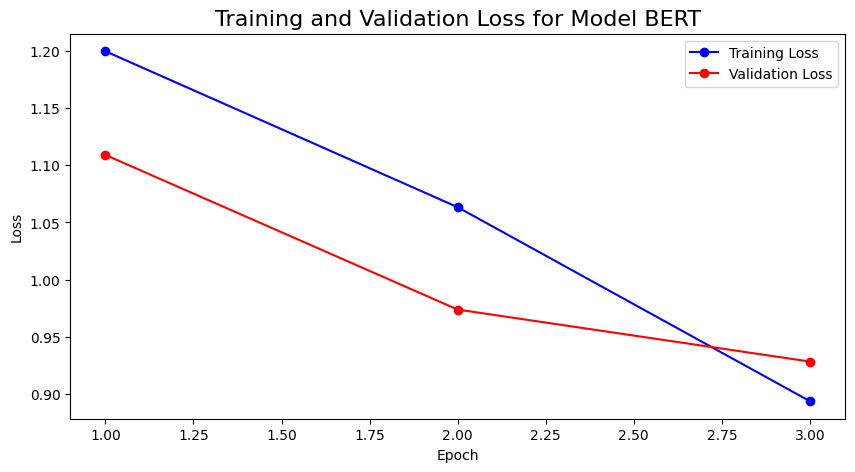

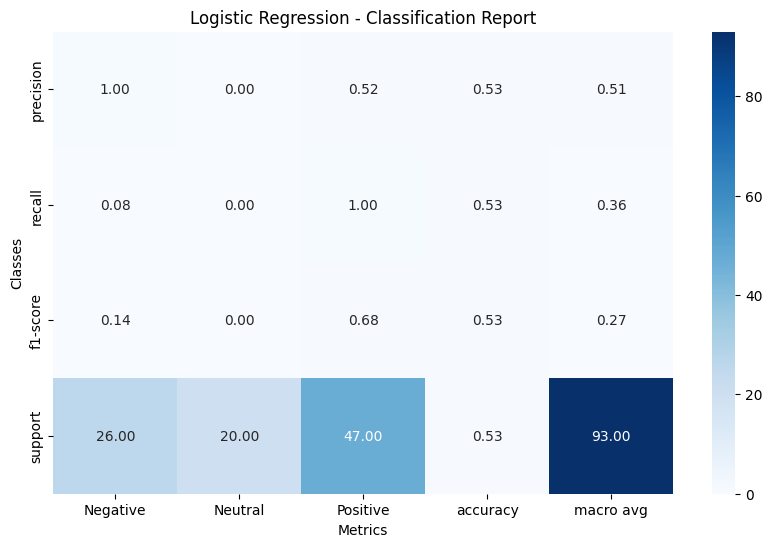

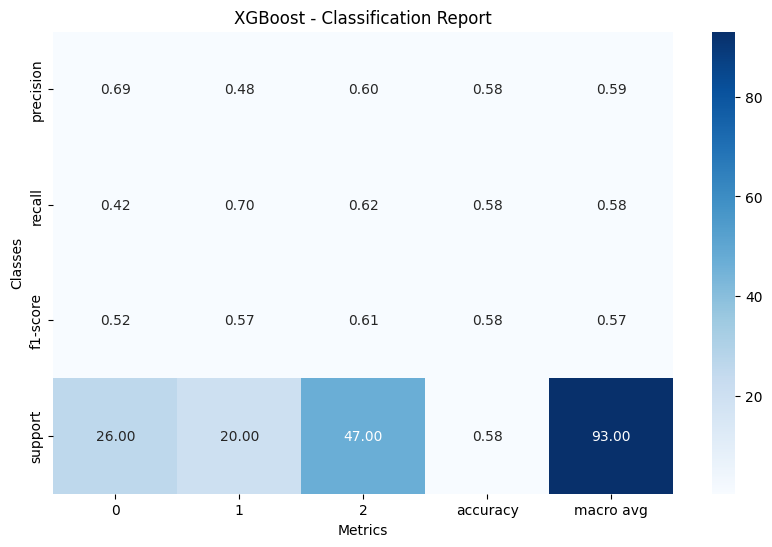

In [37]:
# Assuming y_test and predictions for the models have already been defined

# For Logistic Regression
log_reg_accuracy = accuracy_score(y_test, y_pred_log_reg)
log_reg_classification_report = classification_report(y_test, y_pred_log_reg, output_dict=True)

# For XGBoost
xgb_accuracy = accuracy_score(y_test_encoded, y_pred_xgb)
xgb_classification_report = classification_report(y_test_encoded, y_pred_xgb, output_dict=True, target_names=label_encoder.classes_)

# Manually input the logs here. Example format:
logs = [
    {'loss': 1.199700, 'epoch': 1.0},
    {'eval_loss': 1.109024, 'epoch': 1.0},
    {'loss': 1.063300, 'epoch': 2.0},
    {'eval_loss': 0.973764, 'epoch': 2.0},
    {'loss': 0.893600, 'epoch': 3.0},
    {'eval_loss': 0.928286, 'epoch': 3.0}
]

def plot_metrics(logs, model_name):
    # Separate training and evaluation logs
    train_logs = [log for log in logs if 'loss' in log and 'eval_loss' not in log]
    eval_logs = [log for log in logs if 'eval_loss' in log]

    # Extract relevant metrics if available
    train_epochs = [log['epoch'] for log in train_logs]
    train_loss = [log['loss'] for log in train_logs]
    
    eval_epochs = [log['epoch'] for log in eval_logs]
    eval_loss = [log['eval_loss'] for log in eval_logs]

    plt.figure(figsize=(10, 5))
    plt.title(f'Training and Validation Loss for Model {model_name}', fontsize=16)

    # Plotting Loss
    if train_epochs and train_loss:
        plt.plot(train_epochs, train_loss, label='Training Loss', marker='o', color='blue')
    if eval_epochs and eval_loss:
        plt.plot(eval_epochs, eval_loss, label='Validation Loss', marker='o', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

# Plot the metrics
plot_metrics(logs, "BERT")

# Creating DataFrames for classification reports
log_reg_df = pd.DataFrame(log_reg_classification_report).transpose()
xgb_df = pd.DataFrame(xgb_classification_report).transpose()

# Plotting the classification reports
def plot_classification_report(df, model_name):
    plt.figure(figsize=(10, 6))
    sns.heatmap(df.iloc[:-1, :].T, annot=True, cmap='Blues', fmt='.2f')
    plt.title(f'{model_name} - Classification Report')
    plt.xlabel('Metrics')
    plt.ylabel('Classes')
    plt.show()

# Plot Logistic Regression classification report
plot_classification_report(log_reg_df, 'Logistic Regression')

# Plot XGBoost classification report
plot_classification_report(xgb_df, 'XGBoost')


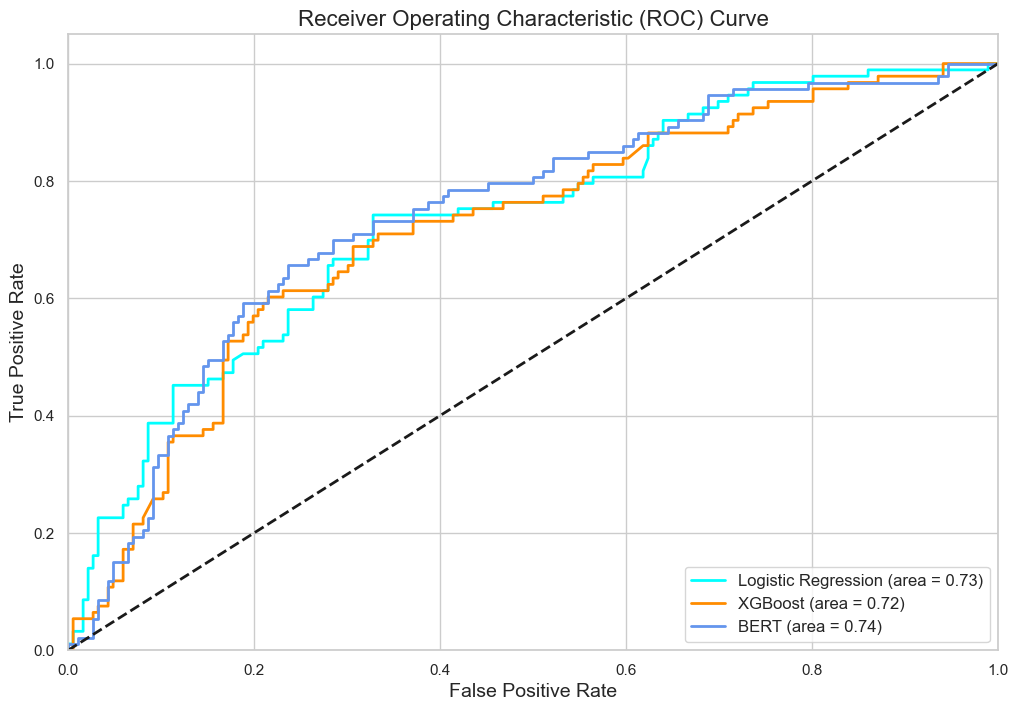

C:\Users\FABIUS\AppData\Local\Temp\ipykernel_1460\151216360.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(models_accuracy.keys()), y=list(models_accuracy.values()), palette="viridis")


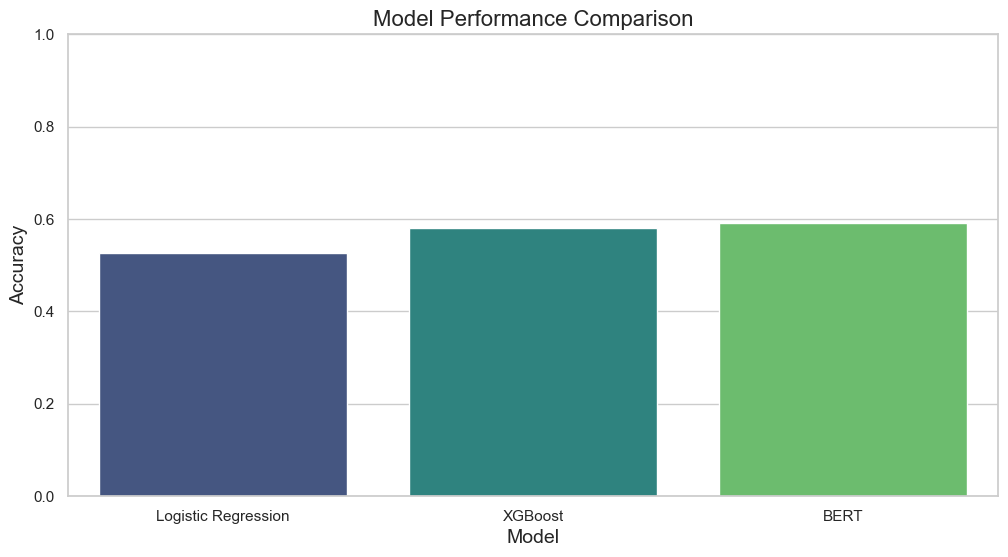

In [47]:
# Assuming y_test and y_test_encoded are already available from your previous code

# Binarize the output
y_test_binarized = label_binarize(y_test, classes=label_encoder.classes_)
n_classes = y_test_binarized.shape[1]

# Logistic Regression
y_score_log_reg = log_reg.decision_function(X_test_tfidf)

# XGBoost
y_score_xgb = xgb_model.predict_proba(X_test_tfidf)

# BERT
y_score_bert = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=-1).numpy()

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

models = {
    'Logistic Regression': y_score_log_reg,
    'XGBoost': y_score_xgb,
    'BERT': y_score_bert
}

for model_name, y_score in models.items():
    for i in range(n_classes):
        fpr[model_name, i], tpr[model_name, i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
        roc_auc[model_name, i] = auc(fpr[model_name, i], tpr[model_name, i])

    # Compute micro-average ROC curve and ROC area
    fpr[model_name, "micro"], tpr[model_name, "micro"], _ = roc_curve(y_test_binarized.ravel(), y_score.ravel())
    roc_auc[model_name, "micro"] = auc(fpr[model_name, "micro"], tpr[model_name, "micro"])

# Plot ROC curves for the models
plt.figure(figsize=(12, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
sns.set(style="whitegrid")

for (model_name, color) in zip(models.keys(), colors):
    plt.plot(fpr[model_name, "micro"], tpr[model_name, "micro"], color=color, lw=2,
             label=f'{model_name} (area = {roc_auc[model_name, "micro"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.show()

# Plot model performance line graph
models_accuracy = {
    'Logistic Regression': accuracy_score(y_test, y_pred_log_reg),
    'XGBoost': accuracy_score(y_test_encoded, y_pred_xgb),
    'BERT': accuracy_score(y_test_encoded, preds)
}

plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

# Plotting the accuracies with bars
sns.barplot(x=list(models_accuracy.keys()), y=list(models_accuracy.values()), palette="viridis")
plt.title('Model Performance Comparison', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.ylim(0, 1)
plt.show()


In [49]:
# Sample input data
data = {
    'TEXT INPUT': [
        "The smartphone's battery life is exceptional and lasts all day.",
        "My new laptop is slow and crashes frequently.",
        "These headphones have average sound quality but are very comfortable.",
        "The smartwatch tracks my fitness activities accurately.",
        "The vacuum cleaner is efficient and works on all surfaces well."
    ],
    'EXPECT RESULT': ["Positive", "Negative", "Neutral", "Positive", "Positive"]
}

# Create DataFrame
df = pd.DataFrame(data)

# Initialize BERT tokenizer and model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Function to get BERT model outputs
def get_bert_output(texts, tokenizer, model):
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=128)
    outputs = model(**inputs)
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1).detach().numpy()
    predicted_labels = np.argmax(probabilities, axis=1)
    return predicted_labels, probabilities

# Get BERT outputs
bert_preds, bert_probs = get_bert_output(df['TEXT INPUT'].tolist(), bert_tokenizer, bert_model)
df['BERT OUT'] = label_encoder.inverse_transform(bert_preds)
df['BERT PROB'] = bert_probs.max(axis=1)

# XGBoost predictions and probabilities
xgb_probs = xgb_model.predict_proba(tfidf.transform(df['TEXT INPUT']))
xgb_preds = np.argmax(xgb_probs, axis=1)
df['XGBOOST OUT'] = label_encoder.inverse_transform(xgb_preds)
df['XGBOOST PROB'] = xgb_probs.max(axis=1)

# Logistic Regression predictions and probabilities
log_reg_probs = log_reg.predict_proba(tfidf.transform(df['TEXT INPUT']))
log_reg_preds = np.argmax(log_reg_probs, axis=1)
df['LOGISTIC OUT'] = label_encoder.inverse_transform(log_reg_preds)
df['LOGISTIC PROB'] = log_reg_probs.max(axis=1)

# Display the DataFrame
print(df)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


                                          TEXT INPUT EXPECT RESULT  BERT OUT  \
0  The smartphone's battery life is exceptional a...      Positive         2   
1      My new laptop is slow and crashes frequently.      Negative         2   
2  These headphones have average sound quality bu...       Neutral         1   
3  The smartwatch tracks my fitness activities ac...      Positive         2   
4  The vacuum cleaner is efficient and works on a...      Positive         2   

   BERT PROB  XGBOOST OUT  XGBOOST PROB  LOGISTIC OUT  LOGISTIC PROB  
0   0.378864            1      0.591316             2       0.656179  
1   0.393317            2      0.725976             2       0.518207  
2   0.373290            1      0.729380             2       0.581468  
3   0.381130            1      0.955020             2       0.486561  
4   0.373292            1      0.873703             2       0.521533  
